In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.optimize import curve_fit
import matplotlib

# Tell notebook server to show plots inline
%matplotlib inline


## Lab 8
Using the lab 4 notebook for reference.

## Part 2a
For the resistor:  Calculate the actual voltage across the resistor, 10 kΩ, subtracting off the 1 Ω resistor voltage if needed. Calculate the current using the 1 Ω voltage and correct for the G+G- offset (systematic error).  Using either Python or Excel, plot the current and voltage data, placing the current measurements on the y-axis.

For both the resistor and the LED:  Perform a linear fit on the curves and add the fit curve to your plot.  Include a plot of the residuals for each fit.

Make sure to label your plot fully.  It should have a descriptive title, axis labels with units, the equation of the line-of-best-fit, the values of the slope and intercept with errors, and the value of 2.
For the resistor:  Determine the resistance R with error from your fit.  Use an agreement test to compare the fit value of resistance with the nominal value.

For each LEDs:  Is the linear fit good compared with the resistor?  Does the LED obey Ohm’s law? Calculate a best fit value of R±R and interpret the results.

Briefly, why are the green and red LED I-V curves slightly different?

At last, you have all your results!  Now it’s time to determine whether or not your data matches the theory.  Then we will determine whether or not your measured value of the resistance can meaningfully be said to agree with the accepted value.

Determine whether or not your reduced chi-squared is too big, too small, or acceptable.  
Interpret these results!  Based on your value of 2, what can you conclude about your experimental results and whether or not your data matches the theory. If your value of 2 is too big or too small, why do you think this might have happened?


In [99]:
part2a = pd.read_csv('part2a.csv')
part2a

,Analog 7 (V),Error (V),High Gain (mV),Error High Gain (V),Voltage 10kOhm,Current 1Ohm (mA)
0,0.0001,0.0004,-0.00362,0.00018,0.00010,0.00035
1,0.3082,0.0013,0.02482,0.00022,0.30817,0.02620
2,0.6293,0.0017,0.05476,0.00022,0.62924,0.05342
3,1.0533,0.0023,0.09411,0.00019,1.05320,0.08919
4,1.3614,0.0031,0.12288,0.00020,1.36127,0.11535
5,1.6823,0.0037,0.15287,0.00018,1.68214,0.14261
6,2.3121,0.0048,0.21206,0.00018,2.31188,0.19642
7,2.6333,0.0041,0.24181,0.00019,2.63305,0.22346
8,2.9539,0.0061,0.27148,0.00017,2.95362,0.25044
9,3.2752,0.0059,0.30155,0.00021,3.27489,0.27777


Propagate error of R:  0     1.143583
1    69.036780
2    69.235241
3    69.581163
4    69.495337
5    69.426717
6    69.129191
7    69.282081
8    69.407142
9    69.362551
dtype: float64
This is the slope:  8.451397448320466e-05
This is resistance:  11832.362708237424


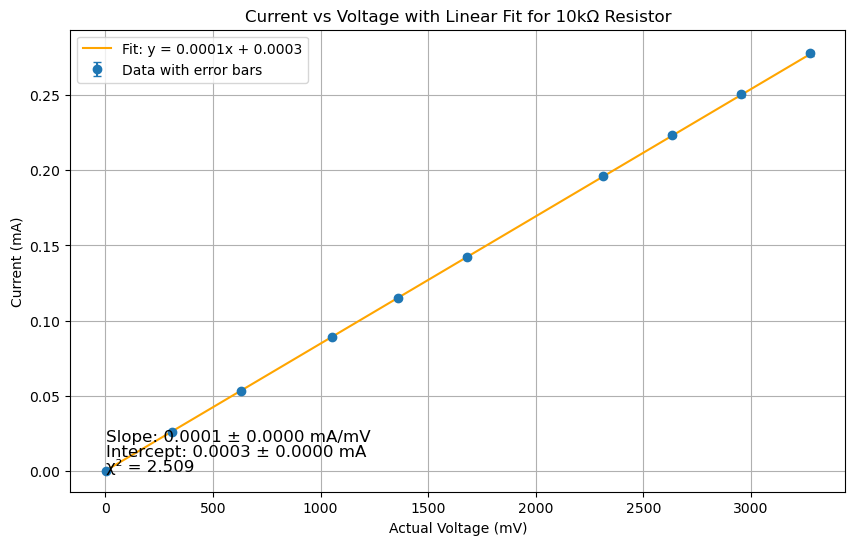

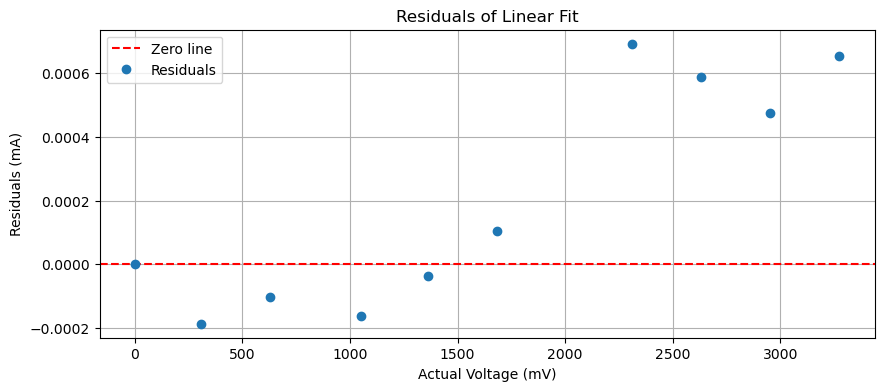

This is the slope error:  9.316221132610179e-08


(11832.362708237424, 13.043157440559908, 1832.3627082374242, 18.32362708237424)

In [100]:
def propagated_error_I(V, R, error_V, error_R):
    return ((error_V/R)**2 + (V/R**2 * error_R))**1/2


def propagated_error_R(V, I, error_V, error_I):
    return np.sqrt((error_V / I)**2 + (V * error_I / I**2)**2)
    
   
x_data = part2a['Voltage 10kOhm']*1000
# this was taken from the uncorrected version of the data where 'Current 1Ohm (mA)' was not multiplied by 1000 to correct for the fact  that the 1ohm resistor 
# was used to convert to Current. However, to convert to Amperes we would need to multiply by 1000 so 'Current 10hm (mA)' is acutally in (A)
y_data = part2a['Current 1Ohm (mA)']

# 10.02 is for the 10kOhm resistor, I'm multiplying it by 1000 to convert to Ohms 10.02*10 is 1% of 10,020ohms
y_error = propagated_error_I(x_data,  np.array([10.02*1000 for i in range(len(x_data))]), part2a['Error (V)'],np.array([10.02*10 for i in range(len(x_data))]))

def plot_everything(x_data, y_data, y_error):
    # Linear model function
    def linear_model(x, m, c):
        return m * x + c

    # Fit the data
    popt, pcov = curve_fit(linear_model, x_data, y_data, sigma=y_error)
    slope, intercept = popt
    print("This is the slope: ", slope)
    
    print("This is resistance: ", 1/slope )
    slope_err, intercept_err = np.sqrt(np.diag(pcov))

    # Residuals
    residuals = y_data - linear_model(x_data, *popt)
    chi_squared = np.sum((residuals / y_error) ** 2)

    # Plot data with fit and error bars
    plt.figure(figsize=(10, 6), dpi=100)
    plt.errorbar(x_data, y_data, yerr=y_error, fmt='o', capsize=3, label="Data with error bars")
    plt.plot(x_data, linear_model(x_data, *popt), label=f'Fit: y = {slope:.4f}x + {intercept:.4f}', color='orange')

    # Adding labels and best fit parameters
    plt.title("Current vs Voltage with Linear Fit for 10kΩ Resistor")
    plt.xlabel("Actual Voltage (mV)")  # Fixed label
    plt.ylabel("Current (mA)")  # Fixed label
    plt.text(0.5, 0.02, f"Slope: {slope:.4f} ± {slope_err:.4f} mA/mV", fontsize=12)
    plt.text(0.5, 0.01, f"Intercept: {intercept:.4f} ± {intercept_err:.4f} mA", fontsize=12)
    plt.text(0.5, 0.0, f"χ² = {chi_squared:.3f}", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot residuals
    plt.figure(figsize=(10, 4), dpi=100)
    plt.errorbar(x_data, residuals, fmt='o', capsize=3, label="Residuals")
    plt.axhline(0, color='red', linestyle='--', label="Zero line")
    plt.title("Residuals of Linear Fit")
    plt.xlabel("Actual Voltage (mV)")
    plt.ylabel("Residuals (mA)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculating resistance R from the fit (1/slope)
    R_fit = 1 / slope
    R_fit_error = slope_err / slope**2
    R_nominal = 10000  # Nominal resistance value (10kΩ)

    # Agreement test (difference between fit and nominal values)
    agreement = abs(R_fit - R_nominal)
    agreement_percentage = (agreement / R_nominal) * 100
    print("This is the slope error: ", slope_err )
    # Return values for further use
    return R_fit, R_fit_error, agreement, agreement_percentage

plot_everything(x_data, y_data, y_error)

In [101]:
r_prop = 1/(8.451397448320466e-05)**2 * 9.316221132610179e-08
r_prop

13.043157440559906

## Part 2B (Green LED)
For the LED:  Calculate the actual voltage across the LED. Calculate the current using the 1 Ω voltage and correct for the G+G- offset (systematic error).  Using either Python or Excel, plot the current and component voltage data, placing the current measurements on the y-axis.


In [102]:
def plot_everything(x_data, y_data, y_error, color):
    # Linear model function
    def linear_model(x, m, c):
        return m * x + c

    # Fit the data
    popt, pcov = curve_fit(linear_model, x_data, y_data, sigma=y_error)
    slope, intercept = popt
    print("This is the slope: ", slope)
    print("This is resistance: ", 1/slope )
    slope_err, intercept_err = np.sqrt(np.diag(pcov))

    # Residuals
    residuals = y_data - linear_model(x_data, *popt)
    chi_squared = np.sum((residuals / y_error) ** 2)

    # Plot data with fit and error bars
    plt.figure(figsize=(10, 6), dpi=100)
    plt.errorbar(x_data, y_data, yerr=y_error, fmt='o', capsize=3, label="Data with error bars")
    plt.plot(x_data, linear_model(x_data, *popt), label=f'Fit: y = {slope:.4f}x + {intercept:.4f}', color='orange')

    # Adding labels and best fit parameters
    plt.title(f"Current vs Voltage with Linear Fit for {color} LED")
    plt.xlabel("Actual Voltage (mV)")  # Fixed label
    plt.ylabel("Current (mA)")  # Fixed label
    plt.text(0.5, 0.20, f"Slope: {slope:.4f} ± {slope_err:.4f} mA/mV", fontsize=12)
    plt.text(0.5, 0.15, f"Intercept: {intercept:.4f} ± {intercept_err:.4f} mA", fontsize=12)
    plt.text(0.5, 0.10, f"χ² = {chi_squared:.3f}", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot residuals
    plt.figure(figsize=(10, 4), dpi=100)
    plt.errorbar(x_data, residuals, fmt='o', capsize=3, label="Residuals")
    plt.axhline(0, color='red', linestyle='--', label="Zero line")
    plt.title("Residuals of Linear Fit")
    plt.xlabel("Actual Voltage (mV)")
    plt.ylabel("Residuals (mA)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculating resistance R from the fit (1/slope)
    R_fit = 1 / slope
    R_fit_error = slope_err / slope**2
    R_nominal = 10000  # Nominal resistance value (10kΩ)

    # Agreement test (difference between fit and nominal values)
    agreement = abs(R_fit - R_nominal)
    agreement_percentage = (agreement / R_nominal) * 100
    r_prop = 1/(slope**2) * slope_err
    print("Rprop: ", r_prop)
    # Return values for further use
    return R_fit, R_fit_error, agreement, agreement_percentage

Index(['Analog 7 (V)', 'Error 7 (V)', 'Analog 8 (V)', 'Error 8 (V)',
       'High Gain (mV)', 'Error High Gain (mV)', 'Green LED Voltage',
       'Current 1Ohm (mA)'],
      dtype='object')
0    0.00003
1   -0.00004
2   -0.00006
3    0.00012
4    0.00008
5   -0.00087
6    0.00126
7    0.25494
8    0.63415
9    0.77881
Name: Current 1Ohm (mA), dtype: float64
This is the slope:  0.08073347330536294
This is resistance:  12.386435998085224


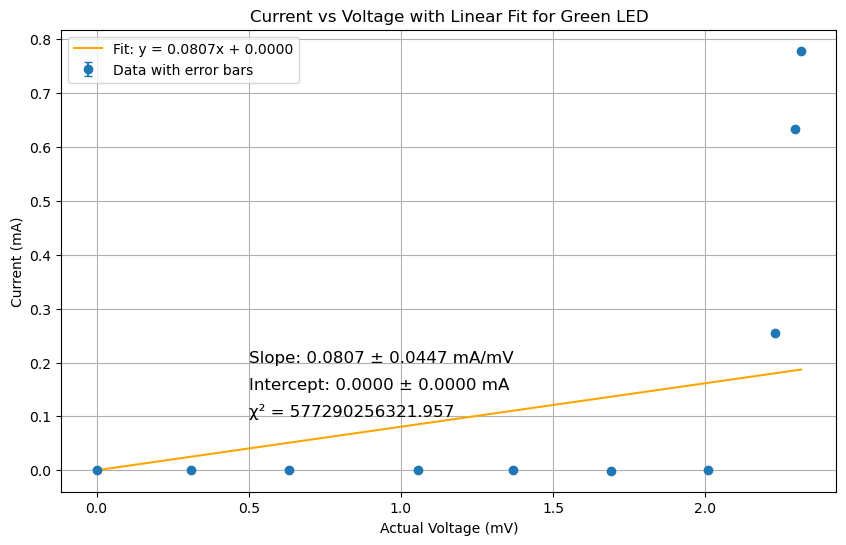

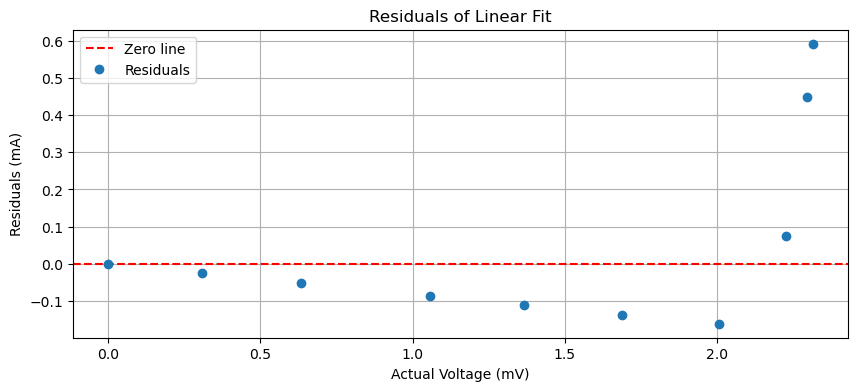

Rprop:  6.855291279349327


(12.386435998085224, 6.855291279349327, 9987.613564001915, 99.87613564001914)

In [103]:
part2bgreen = pd.read_csv('part2bgreen.csv')
print(part2bgreen.columns)
x_data = part2bgreen['Green LED Voltage']
y_data = part2bgreen['Current 1Ohm (mA)']
y_error = propagated_error_I(x_data,  np.array([10.02*1000 for i in range(len(x_data))]), part2a['Error (V)'],np.array([10.02*10 for i in range(len(x_data))]))

print(y_data)
plot_everything(x_data, y_data, y_error, "Green")

Index(['Analog 7 (V)', 'Error 7 (V)', 'Analog 8 (V)', 'Error 8 (V)',
       'High Gain (mV)', 'Error High Gain (V)', 'Red LED Voltage',
       'Current 1Ohm (mA)'],
      dtype='object')
0    0.00003
1   -0.00123
2   -0.00125
3   -0.00004
4   -0.00010
5    0.13314
6    0.60774
7    0.77056
8    0.97155
9    0.97181
Name: Current 1Ohm (mA), dtype: float64
This is the slope:  0.20982782927287585
This is resistance:  4.765812063468116


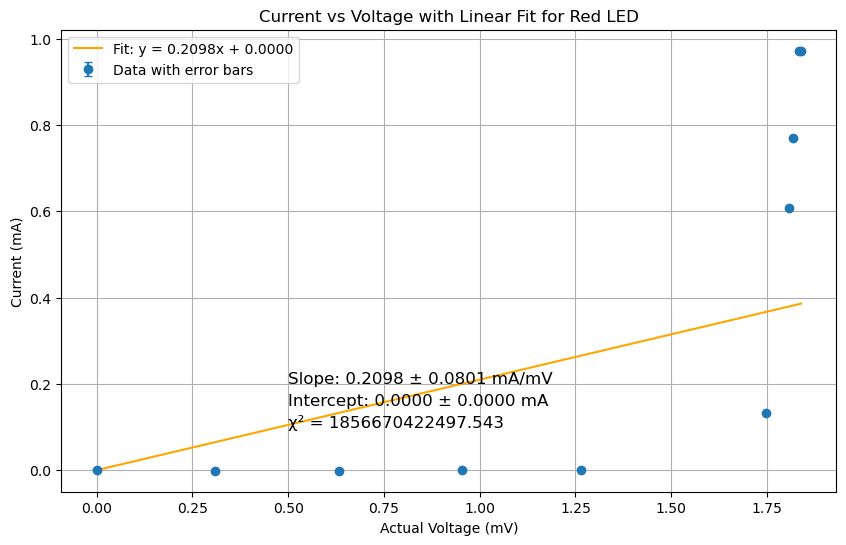

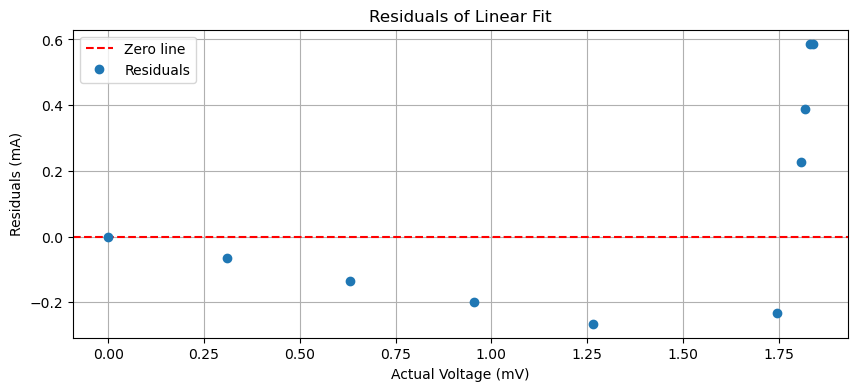

Rprop:  1.8202153610774334


(4.765812063468116, 1.8202153610774336, 9995.234187936532, 99.95234187936532)

In [106]:
part2bred = pd.read_csv('part2bred.csv')
print(part2bred.columns)
x_data = part2bred['Red LED Voltage']
y_data = part2bred['Current 1Ohm (mA)']
y_error = propagated_error_I(x_data,  np.array([10.02*1000 for i in range(len(x_data))]), part2a['Error (V)'],np.array([10.02*10 for i in range(len(x_data))]))

print(y_data)
plot_everything(x_data, y_data, y_error, "Red")

## Error of Resistance


In [105]:
resistor_pred = 118323.62708333845